In [ ]:
# подключим видеокарту
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-64cd60b6-2787-4d30-3569-64f59c32efde)


In [ ]:
#! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c sf-dst-car-price-prediction-part2 -f train.csv
! kaggle competitions download -c sf-dst-car-price-prediction-part2 -f test.csv
! kaggle competitions download -c sf-dst-car-price-prediction-part2 -f sample_submission.csv

  0% 0.00/3.06M [00:00<?, ?B/s]
100% 3.06M/3.06M [00:00<00:00, 102MB/s]
  0% 0.00/747k [00:00<?, ?B/s]
100% 747k/747k [00:00<00:00, 50.1MB/s]
  0% 0.00/21.2k [00:00<?, ?B/s]
100% 21.2k/21.2k [00:00<00:00, 16.5MB/s]


In [ ]:
! unzip test.csv.zip
! unzip train.csv.zip
! unzip sample_submission.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
unzip:  cannot find or open sample_submission.csv.zip, sample_submission.csv.zip.zip or sample_submission.csv.zip.ZIP.


In [ ]:
import pandas as pd
from  sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
pd.set_option('display.max_colwidth', 200)

# Наивная модель

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
train = train[['model_info', 'productionDate', 'price']]
data_train, data_test = train_test_split(train, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    model_info, productionDate = row[0], row[1]
    predicts.append(data_train[(data_train['model_info'] == model_info)
                               & (data_train['productionDate'] == productionDate)]['price'].median())

In [ ]:
# заполним не найденные совпадения
predicts = pd.DataFrame(predicts, columns=['price_predicted'])
data_test = pd.concat([data_test.reset_index(), predicts], axis=1).drop(columns=['index'])

data_test['price_predicted'] = data_test['price_predicted'].fillna(data_test.groupby('productionDate')['price'].transform('median'))

In [ ]:
# округлим цену
data_test['price_predicted'] = (data_test['price_predicted'] // 1000) * 1000

In [ ]:
#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mean_absolute_percentage_error(data_test['price'], data_test['price_predicted']))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 17.56%


# CatBoost

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, по этому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [ ]:
# просмотрим качество заполнения
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [ ]:
# после рассмотрение детально удалим некоторые поля 
features_to_drop = ['sell_id', 'description', 'name', 'vehicleConfiguration', 'Владение']
data.drop(columns=features_to_drop, axis=1, inplace=True)

In [ ]:
# функция приводит в порядок дата-сеты

def putting_order(df):
    # оставляем только название кузова без признака кол-ва дверей и пр
    df['bodyType'] = df['bodyType'].apply(lambda row: row.split()[0])

    # переводим объем двигателя в int
    df['engineDisplacement'] = df['engineDisplacement'].apply(lambda row: 0.0 if len(row.split()[0])>4 else float(row.split()[0])) 
   
    # перводим мощность двигателя в int
    df['enginePower'] = df['enginePower'].apply(lambda row: int(row.split()[0]))

    # извлекаем год объявления  считаем возраст авто
    # df['unix_year'] = pd.to_datetime(df['parsing_unixtime'].astype(int), unit='s').dt.year
    
    # перводим Владельцы в int
    df['Владельцы'] = df['Владельцы'].apply(lambda row: 3 if pd.isna(row)==True else int(row[0]))
    
    # кодируем привод. Наивысший приоритет у полного привода, потом передний и потом задний
    drive_weels = {'полный': 3, 'передний': 2, 'задний': 1}
    df['Привод'] = df['Привод'].map(drive_weels)

    # подрежем milage к более укрупненным цифрам, до 10 000
    df['mileage'] = df['mileage'].apply(lambda row: int(round(row, -4)))

    # просто приводим тип данных к единому формату
    df[['modelDate', 'productionDate']] = df[['modelDate', 'productionDate']].astype(int)
 
    
    return df

In [ ]:
# пропустим данные через функцию подготовки данных
data = putting_order(data)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             8353 non-null   object 
 1   brand                8353 non-null   object 
 2   color                8353 non-null   object 
 3   engineDisplacement   8353 non-null   float64
 4   enginePower          8353 non-null   int64  
 5   fuelType             8353 non-null   object 
 6   mileage              8353 non-null   int64  
 7   modelDate            8353 non-null   int64  
 8   model_info           8353 non-null   object 
 9   numberOfDoors        8353 non-null   int64  
 10  productionDate       8353 non-null   int64  
 11  vehicleTransmission  8353 non-null   object 
 12  Владельцы            8353 non-null   int64  
 13  ПТС                  8353 non-null   object 
 14  Привод               8353 non-null   int64  
 15  Руль                 8353 non-null   o

In [ ]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color',  'fuelType', 'model_info', 
  'numberOfDoors', 'vehicleTransmission',  'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate','engineDisplacement', 'enginePower', 'Владельцы']

In [ ]:
data_set = data.copy()

In [ ]:
def bin_labeling(data_set, columns_list):
    for column in columns_list:
        data_set[column] = LabelEncoder().fit_transform(data_set[column])
    return data_set

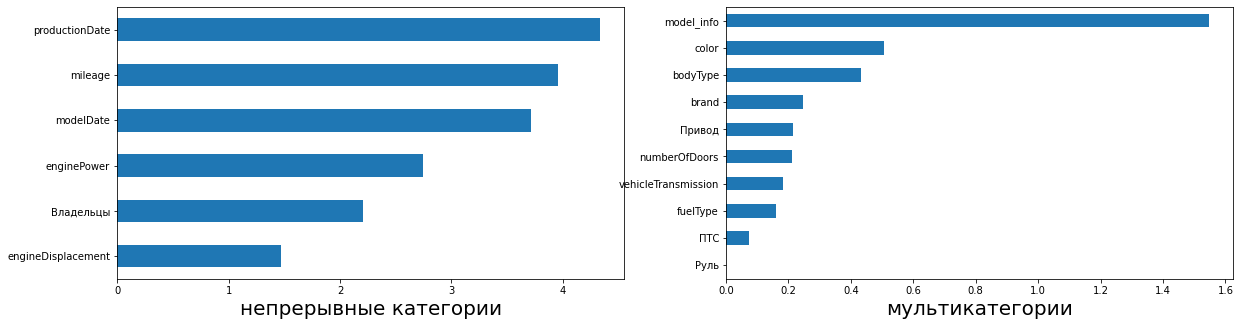

In [ ]:
# тут оценим значимость параметров на цену

import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_classif

# оценка значимости  признаков
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# это количественные признаки 
imp_num = pd.Series(f_classif(data[numerical_features], data['price'])[0], index = numerical_features)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', ax=ax1)
ax1.set_xlabel('непрерывные категории', fontsize=20)

# это мультикатегории
auto_data = bin_labeling(data, categorical_features)
imp_cat = pd.Series(mutual_info_classif(data[categorical_features], data['price'],
                                     discrete_features =True), index = categorical_features)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', ax=ax2)
ax2.set_xlabel('мультикатегории', fontsize=20)

plt.show()

In [ ]:
#Руль и ПТС удалим, низкое влияние
data_set.drop(columns=['Руль', 'ПТС'], axis=1, inplace=True)

In [ ]:
# на всякий случай еще раз уточним числовые и категориальные данные после подготовки
categorical_features = ['bodyType', 'brand', 'color',  'fuelType', 'model_info', 'vehicleTransmission']

numerical_features = ['engineDisplacement', 'enginePower','mileage', 'modelDate', 'numberOfDoors',
                      'productionDate', 'Владельцы', 'Привод']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Нормализуем данные
scaler = MinMaxScaler()
for column in numerical_features:
    data_set[column] = scaler.fit_transform(data_set[[column]])[:,0]

In [ ]:
# Label Encoding
for column in categorical_features:
     data_set[column] = data_set[column].astype('category').cat.codes

In [ ]:
# One-Hot Encoding: 
data_set = pd.get_dummies(data_set, columns=categorical_features, dummy_na=False)
print(data_set.shape)

(8353, 172)


In [ ]:
#Разделяем на train & test часть:

train_data = data_set.query('sample == 1').drop(['sample'], axis=1)
test_data = data_set.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [ ]:
# готовим сеты
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=42)

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 71 kB/s 


In [ ]:
import catboost as ctb

In [ ]:
# формируем модель и обучаем ее
model_best_params = ctb.CatBoostRegressor(iterations = 5000,
                          depth=10, learning_rate=0.15,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          task_type = 'GPU')

model_best_params.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True)
         #plot=True

0:	learn: 0.8779011	test: 0.8975868	best: 0.8975868 (0)	total: 142ms	remaining: 11m 50s
100:	learn: 0.1630201	test: 0.1729098	best: 0.1729098 (100)	total: 10s	remaining: 8m 6s
200:	learn: 0.1550224	test: 0.1662117	best: 0.1662016 (198)	total: 18.8s	remaining: 7m 28s
300:	learn: 0.1498753	test: 0.1642120	best: 0.1634473 (220)	total: 28.1s	remaining: 7m 18s
400:	learn: 0.1491144	test: 0.1643942	best: 0.1634473 (220)	total: 35.9s	remaining: 6m 52s
500:	learn: 0.1420082	test: 0.1583783	best: 0.1581065 (492)	total: 42.2s	remaining: 6m 19s
600:	learn: 0.1374050	test: 0.1547798	best: 0.1547798 (600)	total: 48.5s	remaining: 5m 54s
700:	learn: 0.1342742	test: 0.1528559	best: 0.1527020 (691)	total: 54.9s	remaining: 5m 36s
800:	learn: 0.1337727	test: 0.1529445	best: 0.1526100 (774)	total: 1m 1s	remaining: 5m 21s
900:	learn: 0.1316601	test: 0.1518820	best: 0.1518623 (898)	total: 1m 7s	remaining: 5m 7s
1000:	learn: 0.1312097	test: 0.1516198	best: 0.1515073 (953)	total: 1m 13s	remaining: 4m 55s
1100

In [ ]:
test_predict_catboost = model_best_params.predict(X_test)
print(f"TEST mape: {(mean_absolute_percentage_error(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 13.94%


In [ ]:
# готовим submission
sub_predict_ctb = model_best_params.predict(X_sub)
sample_submission['price'] = sub_predict_ctb
sample_submission.to_csv('catboost_submission.csv', index=False)


In [ ]:
# так же можно поискать более оптимальные параметры при помощи grid search
model = ctb.CatBoostRegressor(iterations = 5000,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          task_type='GPU')
                                                     
# попробуем подобрать макропараметры
grid = {'learning_rate': [0.03, 0.5],
        'depth': [4, 6, 8, 10]}

grid_search_result = model.grid_search(grid, 
                                 X=X_train, 
                                 y=y_train)


Streaming output truncated to the last 5000 lines.
3602:	learn: 0.1121669	test: 0.1501825	best: 0.1501509 (3589)	total: 1m 42s	remaining: 39.9s
3603:	learn: 0.1121678	test: 0.1501847	best: 0.1501509 (3589)	total: 1m 42s	remaining: 39.9s
3604:	learn: 0.1121674	test: 0.1501843	best: 0.1501509 (3589)	total: 1m 42s	remaining: 39.8s
3605:	learn: 0.1121669	test: 0.1501841	best: 0.1501509 (3589)	total: 1m 42s	remaining: 39.8s
3606:	learn: 0.1121674	test: 0.1501822	best: 0.1501509 (3589)	total: 1m 42s	remaining: 39.8s
3607:	learn: 0.1121660	test: 0.1501841	best: 0.1501509 (3589)	total: 1m 42s	remaining: 39.7s
3608:	learn: 0.1121599	test: 0.1501887	best: 0.1501509 (3589)	total: 1m 43s	remaining: 39.7s
3609:	learn: 0.1121530	test: 0.1501880	best: 0.1501509 (3589)	total: 1m 43s	remaining: 39.7s
3610:	learn: 0.1121522	test: 0.1501882	best: 0.1501509 (3589)	total: 1m 43s	remaining: 39.6s
3611:	learn: 0.1121497	test: 0.1501847	best: 0.1501509 (3589)	total: 1m 43s	remaining: 39.6s
3612:	learn: 0.1121

In [ ]:
print(grid_search_result.get('params'))

{'depth': 8, 'l2_leaf_reg': 9, 'learning_rate': 0.1}


# **SNN по количественным и категориальным показателям**

In [ ]:
# импорты

import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.layers as L
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import  load_model

In [ ]:
model_snn = tf.keras.Sequential([
L.Dense(512, input_dim=X_train.shape[1], activation="relu"),
L.Dropout(0.5),
L.Dense(256, activation="relu"),
L.Dropout(0.5),
L.Dense(1, activation="linear")])

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.05)
model_snn.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
# обавим чекпоинты

checkpoint = ModelCheckpoint('best_model_snn.hdf5' , monitor='val_MAPE', verbose=0  , mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
# функция вывода графиков обучения
def show_learn_graf(history):
      
      fig = plt.figure(figsize=(25,6))

      plt.plot(history.history['MAPE'], 'b', label='Training mape')
      plt.plot(history.history['val_MAPE'], 'r', label='Validation mape')
      plt.title('Training and validation MAPE')
      plt.legend()
      plt.show()


In [ ]:
history_snn = model_snn.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

Epoch 1/500
12/12 [==============================] - 1s 37ms/step - loss: 99.4901 - MAPE: 99.4901 - val_loss: 95.5689 - val_MAPE: 95.5689
Epoch 2/500
12/12 [==============================] - 0s 9ms/step - loss: 78.5608 - MAPE: 78.5608 - val_loss: 49.0588 - val_MAPE: 49.0588
Epoch 3/500
12/12 [==============================] - 0s 10ms/step - loss: 53.1121 - MAPE: 53.1121 - val_loss: 46.7786 - val_MAPE: 46.7786
Epoch 4/500
12/12 [==============================] - 0s 10ms/step - loss: 46.9502 - MAPE: 46.9502 - val_loss: 44.0552 - val_MAPE: 44.0552
Epoch 5/500
12/12 [==============================] - 0s 11ms/step - loss: 43.4114 - MAPE: 43.4114 - val_loss: 41.5278 - val_MAPE: 41.5278
Epoch 6/500
12/12 [==============================] - 0s 10ms/step - loss: 40.7812 - MAPE: 40.7812 - val_loss: 39.2078 - val_MAPE: 39.2078
Epoch 7/500
12/12 [==============================] - 0s 10ms/step - loss: 38.9405 - MAPE: 38.9405 - val_loss: 37.2768 - val_MAPE: 37.2768
Epoch 8/500
12/12 [================

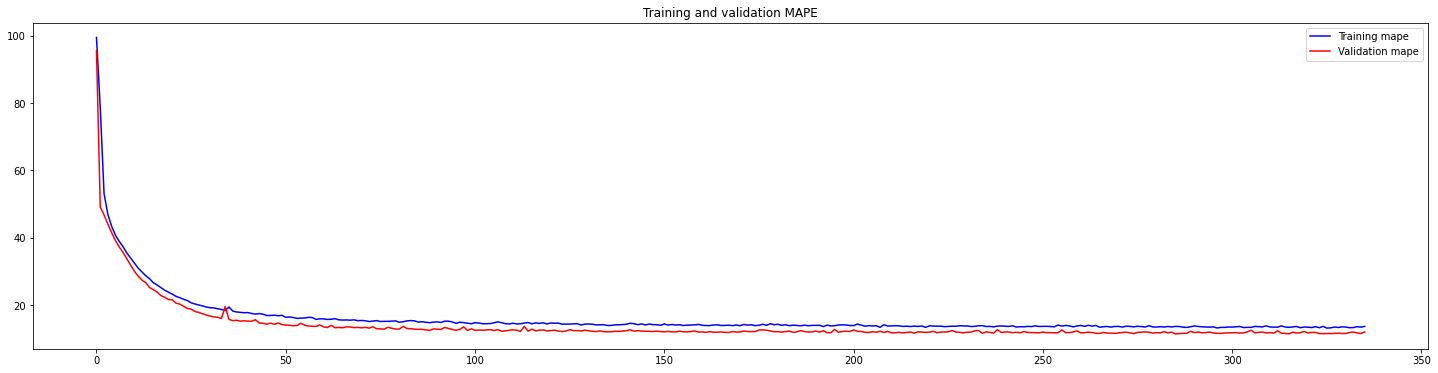

In [ ]:
show_learn_graf(history_snn)

In [ ]:
# загружаем лучщую модель
model_best_snn= load_model('best_model_snn.hdf5') 

In [ ]:
test_predict_snn = model_best_snn.predict(X_test)
print(f"TEST mape: {(mean_absolute_percentage_error(y_test, test_predict_snn[:,0]))*100:0.2f}%")

TEST mape: 11.42%


# *Комбинированая модель текст + табличные данные*

In [ ]:
# импортируем соответствующие библиотеки

import nltk as nltk
import re
from collections import Counter
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import RegexpTokenizer
import nltk as nltk
#import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_rows', 200)

In [ ]:
# импортируем необходимые пакеты nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# функция для обработки текста

def text_process(text_list):
    # удалим все integer
    text_list = text_list.lower()
    text_list = re.sub(r'\d\s*', '', text_list)
    text_list = re.sub(r'\W', ' ', text_list)
    text_list = re.sub(r'\b.\b', ' ', text_list)
    text_list = re.sub("\s+", " ", text_list)
    text_list = re.sub("_", "", text_list)

    # токенизируем до слов
    text_list = nltk.word_tokenize(text_list)

    # тут убираем знаки препинания
    text_list = list(filter(lambda name: name.isalnum(), text_list))

    # тут удаляем stop-words
    stop_words = nltk.corpus.stopwords.words('russian')
    text_list = list(filter(lambda name: not name in stop_words, text_list))

    # тут удаляем слова до 3-х букв
    text_list = list(filter(lambda name: len(name) > 3, text_list))

    # сделаем лемматизацию
    lemmatizer = nltk.stem.WordNetLemmatizer()
    text_list = list(map(lambda name: lemmatizer.lemmatize(name), text_list))

    # stemmer
    stemmer = nltk.stem.SnowballStemmer("russian")
    text_list = list(map(lambda name: stemmer.stem(name), text_list))

    return text_list

In [ ]:
# опять импортируем данные, так как в предыдущих удалили текстовое поле
train = pd.read_csv('/content/train/train.csv')
test = pd.read_csv('/content/train/test.csv')

In [ ]:
# повторяем операцию с объединенем сетов
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, по этому пока просто заполняем нулями

data = test[['description', 'sample']].append(train[['description', 'sample']], sort=False).reset_index(drop=True) # объединяем

print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 2)


In [ ]:
# прогоняем текст через функцию обработки

text_train = pd.DataFrame(data['description'].apply(lambda row: text_process(row)))
text_train.columns = ['normed']
text_train['normilized'] = text_train['normed'].apply(lambda row: str(' '.join(row)))

In [ ]:
# соберем статистики про словам
word_count = pd.DataFrame(Counter(" ".join(text_train['normilized'].values.tolist()).split(" ")).items(),columns=['word', 'count'])
print(word_count['word'].count(), 'слов')

16302 слов


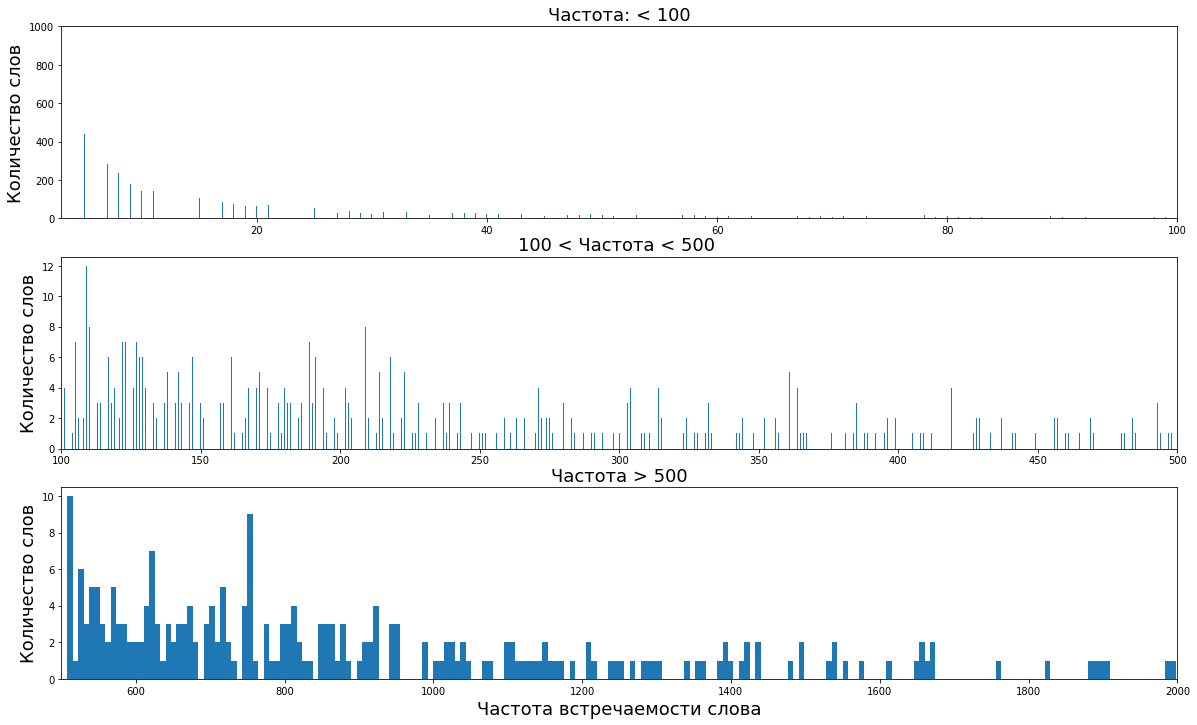

In [ ]:
# посмотрим частоту распределение встречаемости слов

import matplotlib.pyplot as plt
%matplotlib inline

# Посмотрим распределение количества слов в описаниях
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)


ax1.hist(word_count[word_count['count'] <100]['count'], bins = 2000)
ax1.set(xlim=(3,100), ylim=(0,1000))

ax2.hist(word_count[(word_count['count'] >100) & (word_count['count'] <500)]['count'], bins = 2000)
ax2.set(xlim=(100,500))

ax3.hist(word_count[word_count['count'] >500]['count'], bins = 2000)
ax3.set(xlim=(500,2000))


#Добавляем подписи
ax1.set_title('Частота: < 100',fontsize=18)
ax1.set_ylabel('Количество слов', fontsize=18)

ax2.set_title('100 < Частота < 500 ',fontsize=18)
ax2.set_ylabel('Количество слов', fontsize=18)

ax3.set_title('Частота > 500',fontsize=18)
ax3.set_ylabel('Количество слов', fontsize=18)
ax3.set_xlabel('Частота встречаемости слова', fontsize=18)


plt.show()

In [ ]:
# посмотрим количество слов по диапазонам частоты встречаемости
# идея слудующая: слёишком частые слова - будут встречаться везде и не принесут пользы, слишком редкие слова - тоже плохо

print('менее 100:',word_count[word_count['count'] <100]['count'].count(),
      '\n100 - 500:',word_count[(word_count['count'] >100) & (word_count['count'] <500)]['count'].count(),
      '\nболее 500:',word_count[word_count['count'] >500]['count'].count())

менее 100: 15262 
100 - 500: 750 
более 500: 277


In [ ]:
# этой функцией будем оставлять только те слова, которые находятся в одном из диапазонов

words_left=word_count[(word_count['count'] >100) & (word_count['count'] <500)]['word']
text_train['descr_reduced'] = ''

for row in text_train.index:
    text_train['descr_reduced'].iloc[row] = list(filter(lambda name: name in list(words_left), text_train['normed'].iloc[row]))

In [ ]:
# сформируем поле, где будут только слова из целевого диапазона
text_train['reduced_row'] = text_train['descr_reduced'].apply(lambda row: str(' '.join(row)))
test = pd.DataFrame(Counter(" ".join(text_train['reduced_row'].values.tolist()).split(" ")).items(),columns=['word', 'count'])

In [ ]:
# начнем подготовку данных для сетки
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# формируем train-матрицу с индексированными словами
MAX_LENGTH = 300
MAX_WORDS = 100000

MAX_SEQUENCE_LENGTH = 300
tokenize = Tokenizer(num_words=MAX_WORDS)

train_text = text_train['reduced_row'].iloc[X_train.index]
test_text = text_train['reduced_row'].iloc[X_test.index]

sequences_train = tokenize.texts_to_sequences(train_text)
train_padded = pad_sequences(sequences_train, maxlen=MAX_LENGTH, padding='post', truncating="post")

sequences_test = tokenize.texts_to_sequences(test_text)
test_padded = pad_sequences(sequences_test, maxlen=MAX_LENGTH, padding='post', truncating="post")
print(train_padded.shape, test_padded.shape)


(5679, 300) (1003, 300)


In [ ]:
model_nlp = tf.keras.Sequential([
tf.keras.layers.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
tf.keras.layers.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
tf.keras.layers.LSTM(256, return_sequences=True),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.LSTM(128,),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Dense(64, activation="relu"),
tf.keras.layers.Dropout(0.25)])

In [ ]:
model_mlp = tf.keras.Sequential([
tf.keras.layers.Dense(512, input_dim=X_train.shape[1], activation="relu"),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(256, activation="relu"),
tf.keras.layers.Dropout(0.5)])

In [ ]:
# скомбинируем вход двух моделей
combinedInput = tf.keras.layers.concatenate([model_nlp.output, model_mlp.output])

head = tf.keras.layers.Dense(64, activation="relu")(combinedInput)
head = tf.keras.layers.Dense(1, activation="linear")(head)

model_combined = tf.keras.Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
# добавим чек-поинты
checkpoint = ModelCheckpoint('best_model_combined.hdf5', monitor='val_MAPE', verbose=0, mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_combined.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
# обучаем модель

history_combined = model_combined.fit([train_padded, X_train], y_train,
                    batch_size=512,
                    epochs=500, # обучаем пока EarlyStopping не остановит обучение
                    validation_data=([test_padded, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 12s 661ms/step - loss: 99.9801 - MAPE: 99.9801 - val_loss: 99.7810 - val_MAPE: 99.7810
Epoch 2/500
12/12 [==============================] - 7s 552ms/step - loss: 98.2259 - MAPE: 98.2259 - val_loss: 92.2079 - val_MAPE: 92.2079
Epoch 3/500
12/12 [==============================] - 6s 536ms/step - loss: 75.8978 - MAPE: 75.8978 - val_loss: 49.2007 - val_MAPE: 49.2007
Epoch 4/500
12/12 [==============================] - 6s 528ms/step - loss: 51.8766 - MAPE: 51.8766 - val_loss: 47.3381 - val_MAPE: 47.3381
Epoch 5/500
12/12 [==============================] - 6s 532ms/step - loss: 47.4879 - MAPE: 47.4879 - val_loss: 45.3720 - val_MAPE: 45.3720
Epoch 6/500
12/12 [==============================] - 6s 533ms/step - loss: 44.4479 - MAPE: 44.4479 - val_loss: 43.2657 - val_MAPE: 43.2657
Epoch 7/500
12/12 [==============================] - 6s 535ms/step - loss: 42.3853 - MAPE: 42.3853 - val_loss: 41.2041 - val_MAPE: 41.2041
Epoch 8/500
12/12 [=======

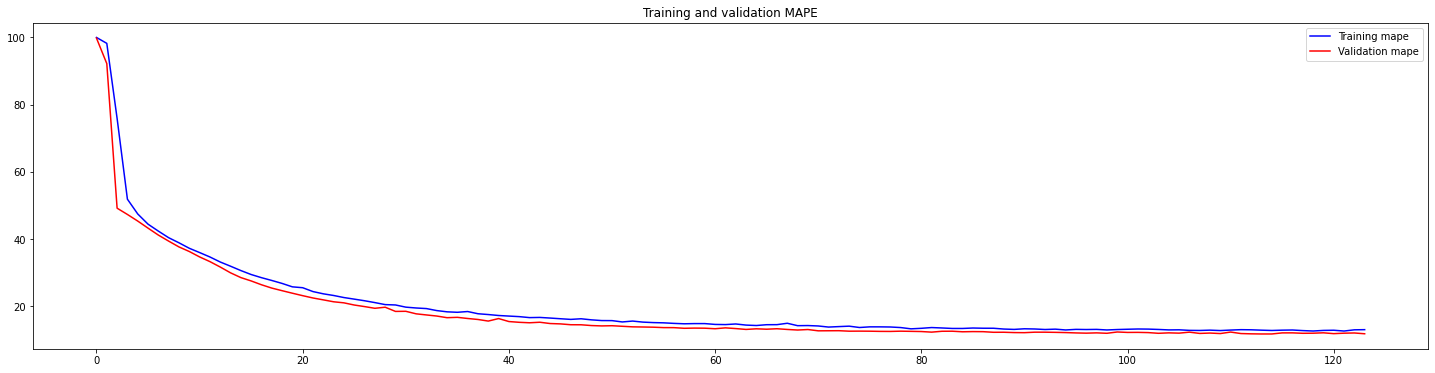

In [ ]:
show_learn_graf(history_combined)

In [ ]:
# загружаем лучщую модель
model_best_combined= load_model('best_model_combined.hdf5') 

In [ ]:
test_predict_combined = model_combined.predict([test_padded, X_test])
print(f"TEST mape: {(mean_absolute_percentage_error(y_test, test_predict_combined[:,0]))*100:0.2f}%")

TEST mape: 11.79%


In [ ]:
import os, signal

os.kill(     os.getpid() , 
         signal.SIGKILL
       )